# Мрежа VGG-16 и задатак класификације

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/Petlja/specit4_ai_radni/blob/main/мрежа_VGG-16_и_задатак_класификације_слика.ipynb)

У овој свесци можеш опробати како заиста раде конволутивне неуронске мреже. Користићемо мрежу VGG-16 и тестирати је у задатку класификације слика. На располагању имамо чак 1000 класа!

На самом почетку учитаћемо стандардне библиотеке које су нам неопходне за даљи рад.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Посебно, из библиотеке TensorFlow учитавамо истрениран модел VGG-16. Приликом учитавања овог модела потребно је да нагласимо да желимо да користимо модел који је обучаван на сликама из скупа ImageNet. То можемо урадити тако што ћемо поставити аргумент `weights` функције `VGG16` која се користи за учитавање модела на вредност `imagenet`. Само учитавање модела ће мало потрајати.

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 8s 0us/step


Даље ћемо се уверити од којих се све слојева састоји ова мрежа. Немој да те збуни ако не разумеш све детаље који се приказују. Важно је да знаш да се на улазу очекује слика димензије 224x224 пиксела у боји (зато је и поред улазног слоја наведено 224, 224, 3) и да на излазу имаш једну од 1000 класа. Испис можеш да упоредиш и са сликом модела VGG-16 коју смо разматрали и тако откријеш више информација.

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Можемо да видимо да је број параметара ове мреже преко 138 милиона. Ми мрежу нећемо тренирати, већ ћемо само корисити истрениран модел. Зато је важно да параметре модела у току рада не мењамо - сваки има свој допринос.

Идеја је да слика над којом ћемо тестирати мрежу буде нека произвољна слика са веба. Да бисмо то успели да урадимо користићемо пар библиотека. Библиотека PIL је стандардна библиотека језика Python за рад са сликама док ћемо библиотеке urlib и io искористити за учитавање слике.

In [ ]:
from PIL import Image
from urllib import request
from io import BytesIO

Функција `ucitaj_sliku` ће нам помоћи да превучемо коју год слику желимо са веба. Довољно је да јој задамо URL путању.

In [ ]:
def ucitaj_sliku (url_putanja):
    odgovor = request.urlopen(url_putanja).read()
    return Image.open(BytesIO(odgovor))

Ми смо одабрали слику слику златног ретривера! Променом путање у променљивој `putanja_do_slike` можеш да поставиш слику коју желиш.

In [ ]:
putanja_do_slike = 'https://images.unsplash.com/photo-1558788353-f76d92427f16?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=738&q=80' # https://unsplash.com/photos/x5oPmHmY3kQ
test_slika = ucitaj_sliku(url_putanja=putanja_do_slike)

Сада ћемо и приказати учитану слику.

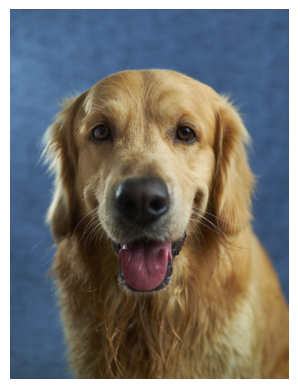

In [ ]:
plt.imshow(test_slika)
plt.axis('off')
plt.show()

Приликом избора слике важно је имати на уму да класа објекта на слици мора бити позната моделу. Пошто је модел VGG-16 трениран на преко 1.2 милиона слика познаје јако пуно објеката, чак 1000 различитих. Како је упознао златног ретривера можемо очекивати добар резултат. Уколико моделу дамо слику са неким објектом који не познаје, даће нам предикције класа чије слике највише подсећају на нашу. Видећемо на крају које све класе објеката наликују на златног ретривера.

Пошто слика коју треба да проследимо моделу, треба да буде специјално припремљена, следи део са припремама.

Учитаћемо и пар библиотека које ће нам олакшати посао. Уобичајено је да приликом дељења модела заједница подели и све пропратне функционалости које нам значе у тим корацима.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

Прво ћемо припремити слику тако што ћемо јој поставити димензије на 224x224 и рећи да користи три канала боја RGB.


In [ ]:
test_slika = test_slika.resize((224, 224))
test_slika = test_slika.convert('RGB')

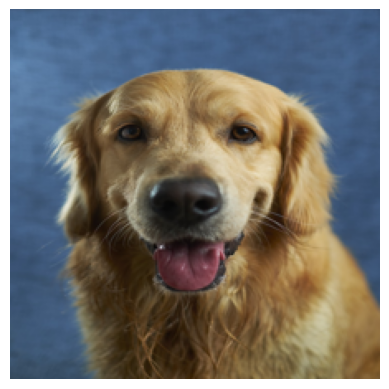

In [ ]:
plt.imshow(test_slika)
plt.axis('off')
plt.show()

Даље ћемо се осигурати да је слика у одговарајућем матричном формату.

In [ ]:
matricni_oblik_test_slike = image.img_to_array(test_slika)
print(matricni_oblik_test_slike.shape)

(224, 224, 3)


Као што знаш, мреже увек раде са пакетићима података. Зато ћемо направити и пакетић који садржи нашу слику. Као што очекујеш његова димензија ће бити 1 x 224 x 224 x 3 јер имамо само једну слику у пакетићу.

In [ ]:
paketic = np.expand_dims(matricni_oblik_test_slike, axis=0)
print(f'(broj_test_slika, visina, sirina, broj_kanal) = {paketic.shape}')

(broj_test_slika, visina, sirina, broj_kanal) = (1, 224, 224, 3)


Даље следи део који се тиче нумеричког претпроцесирања слике у виду нормализације. У томе ће нам помоћи посебна функција `preprocess_input` која прати модел.

In [ ]:
test_skup_slika = preprocess_input(paketic)

Пошто смо завршили са припремом, сада можемо да искористимо модел за задатак класификације. Функција која ће нам помоћи у том делу се зове `predict`.

In [ ]:
predikcije_modela = model.predict(test_skup_slika)

1/1 [==============================] - 1s 945ms/step


Добијене предикције модела представљају вероватноће припадности наше слике свакој од 1000 класа.

In [ ]:
predikcije_modela.shape

(1, 1000)

Да бисмо издвојили класу којој припада наша слика, можемо искорисити функцију `decode_predictions` која ће нам вратити вероватноће и имена за 5 највероватнијих класа. Ово ће нам дати увид у то колико је модел сигуран приликом класификације.

In [ ]:
najverovatnije_klase = decode_predictions(predikcije_modela)[0]
print(najverovatnije_klase)

35363/35363 [==============================] - 0s 0us/step
[('n02099601', 'golden_retriever', 0.8042132), ('n02099267', 'flat-coated_retriever', 0.025630273), ('n02099712', 'Labrador_retriever', 0.018470524), ('n04409515', 'tennis_ball', 0.018086748), ('n02099849', 'Chesapeake_Bay_retriever', 0.01418321)]


Као што можемо да видимо, на првом месту је класа *golden retriever* и то са вероватноћом 0.8042132. Да бисмо лакше испратили излаз модела, можемо га и графички приказати.

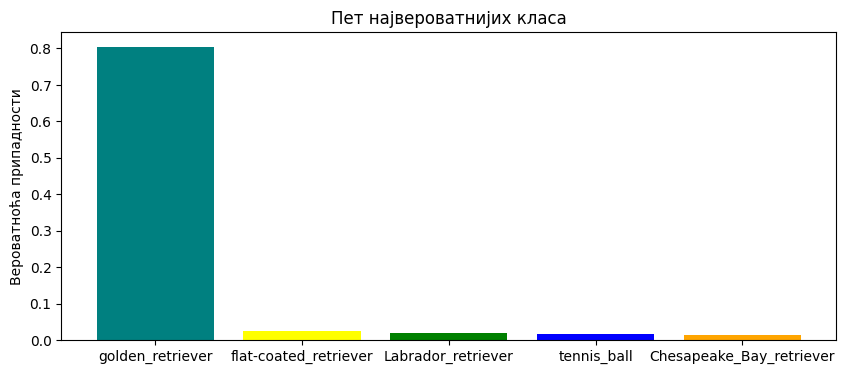

In [ ]:
ime_klase = [torka[1] for torka in najverovatnije_klase]
verovatnoca_pripadnosti = [torka[2] for torka in najverovatnije_klase]
plt.figure(figsize=(10, 4))
plt.bar(ime_klase, verovatnoca_pripadnosti, color=['teal', 'yellow', 'green', 'blue', 'orange'])
plt.title('Пет највероватнијих класа')
plt.ylabel('Вероватноћа припадности')
plt.show()

Видимо да је модел са великом сигурношћу предвидео да је слика коју смо одабрали слика златног ретривера. Неке од других класа које је модел узео у обзир су неке друге врсте ретривера. Необично је да се у листи резултата појавила и тениска лоптица. :)